### 使用pymc模拟的方式求解捕食者模型
- 要求数据足够

In [8]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pymc as pm
from pymc.ode import DifferentialEquation

from itertools import product
import os.path as osp
from scipy.optimize import leastsq
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
import time
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
from IPython.display import display as print

from scipy.integrate import odeint


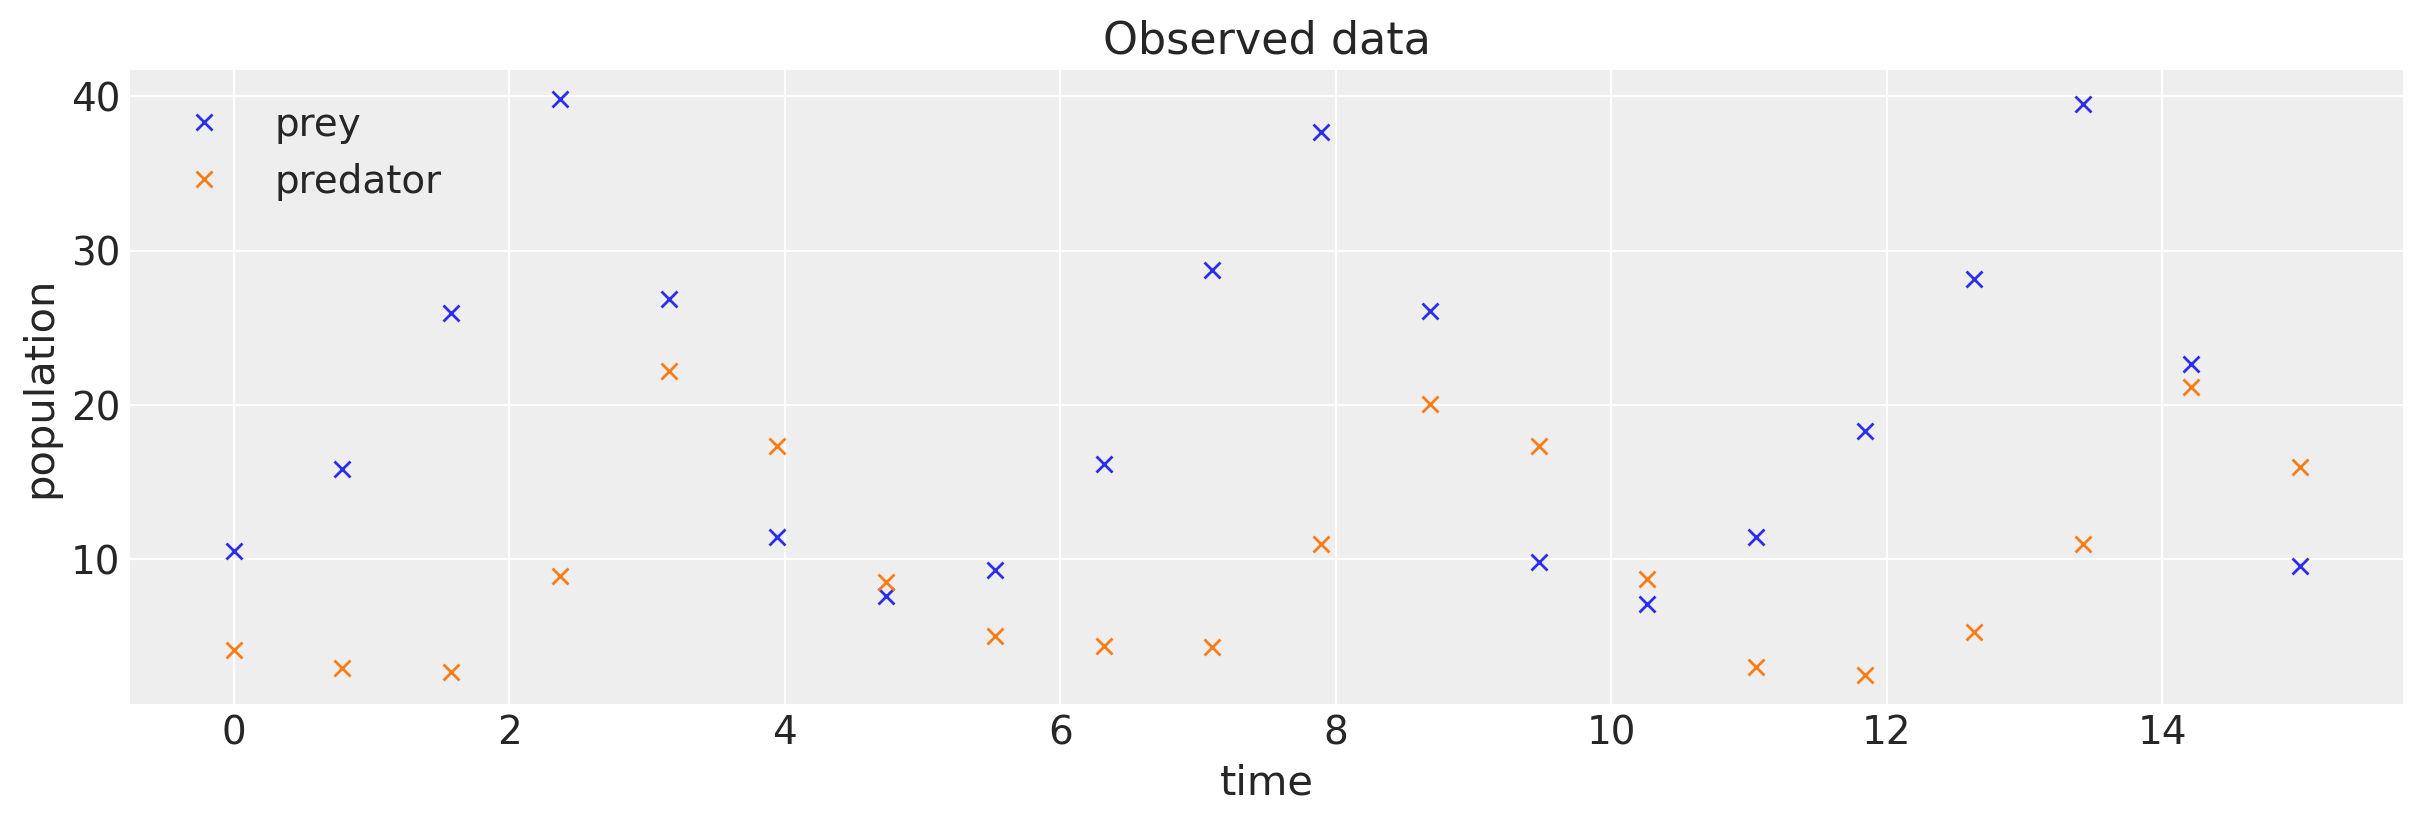

In [9]:
# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
y0 = [10.0, 5.0]
# size of data
size = 20
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(y, t, a, b, c, d):
    """Return the growth rate of fox and rabbit populations."""

    return np.array([a * y[0] - b * y[0] * y[1], -c * y[1] + d * b * y[0] * y[1]])


# simulator function
def competition_model(rng, y0, a, b, size=None):
    
    return odeint(dX_dt, y0=y0, t=t, rtol=0.01, args=(a, b, c, d))

# function for generating noisy data to be used as observed data.
def add_noise(y0, a, b):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(None, y0, a, b) + noise
    return simulated

# plotting observed data.
observed = add_noise(y0, a, b)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, observed[:, 0],"x", label="prey")
ax.plot(t, observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [10]:
print(observed.shape)
print(t.shape)
observed[:, 0]


(20, 2)

(20,)

array([10.52738264, 15.80680219, 25.94363798, 39.81609137, 26.83542718,
       11.45564734,  7.61474862,  9.25832486, 16.1913707 , 28.74935418,
       37.66138678, 26.09302943,  9.7960695 ,  7.11160848, 11.41923371,
       18.30204267, 28.17572124, 39.52349265, 22.66166649,  9.57408675])

In [11]:
from IPython.display import clear_output, display, HTML



In [12]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0)
    b = pm.HalfNormal("b", 1.0)
    
    # y0_1 = pm.HalfNormal("y0_1", 10)
    # y0_2 = pm.HalfNormal("y0_2", 10)

    y0_1 = pm.HalfNormal("y0_1", 10)
    y0_2 = pm.HalfNormal("y0_2", 5)
    # y0_1,y0_2 = 10, 5

    sim = pm.Simulator("sim", competition_model, params=((y0_1,y0_2), a, b), epsilon=0.001, observed=observed,distance="laplace")

    idata_lv = pm.sample_smc(draws=2000, cores=1)

/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_91898/2351611970.py:19: RuntimeWarning: invalid value encountered in scalar subtract
  return np.array([a * y[0] - b * y[0] * y[1], -c * y[1] + d * b * y[0] * y[1]])
/var/folders/90/l1bfwzjx4ms6v5_k7236h2n40000gn/T/ipykernel_91898/2351611970.py:19: RuntimeWarning: overflow encountered in scalar multiply
  return np.array([a * y[0] - b * y[0] * y[1], -c * y[1] + d * b * y[0] * y[1]])
We recommend running at least 4 chains for robust computation of convergence diagnostics


/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data

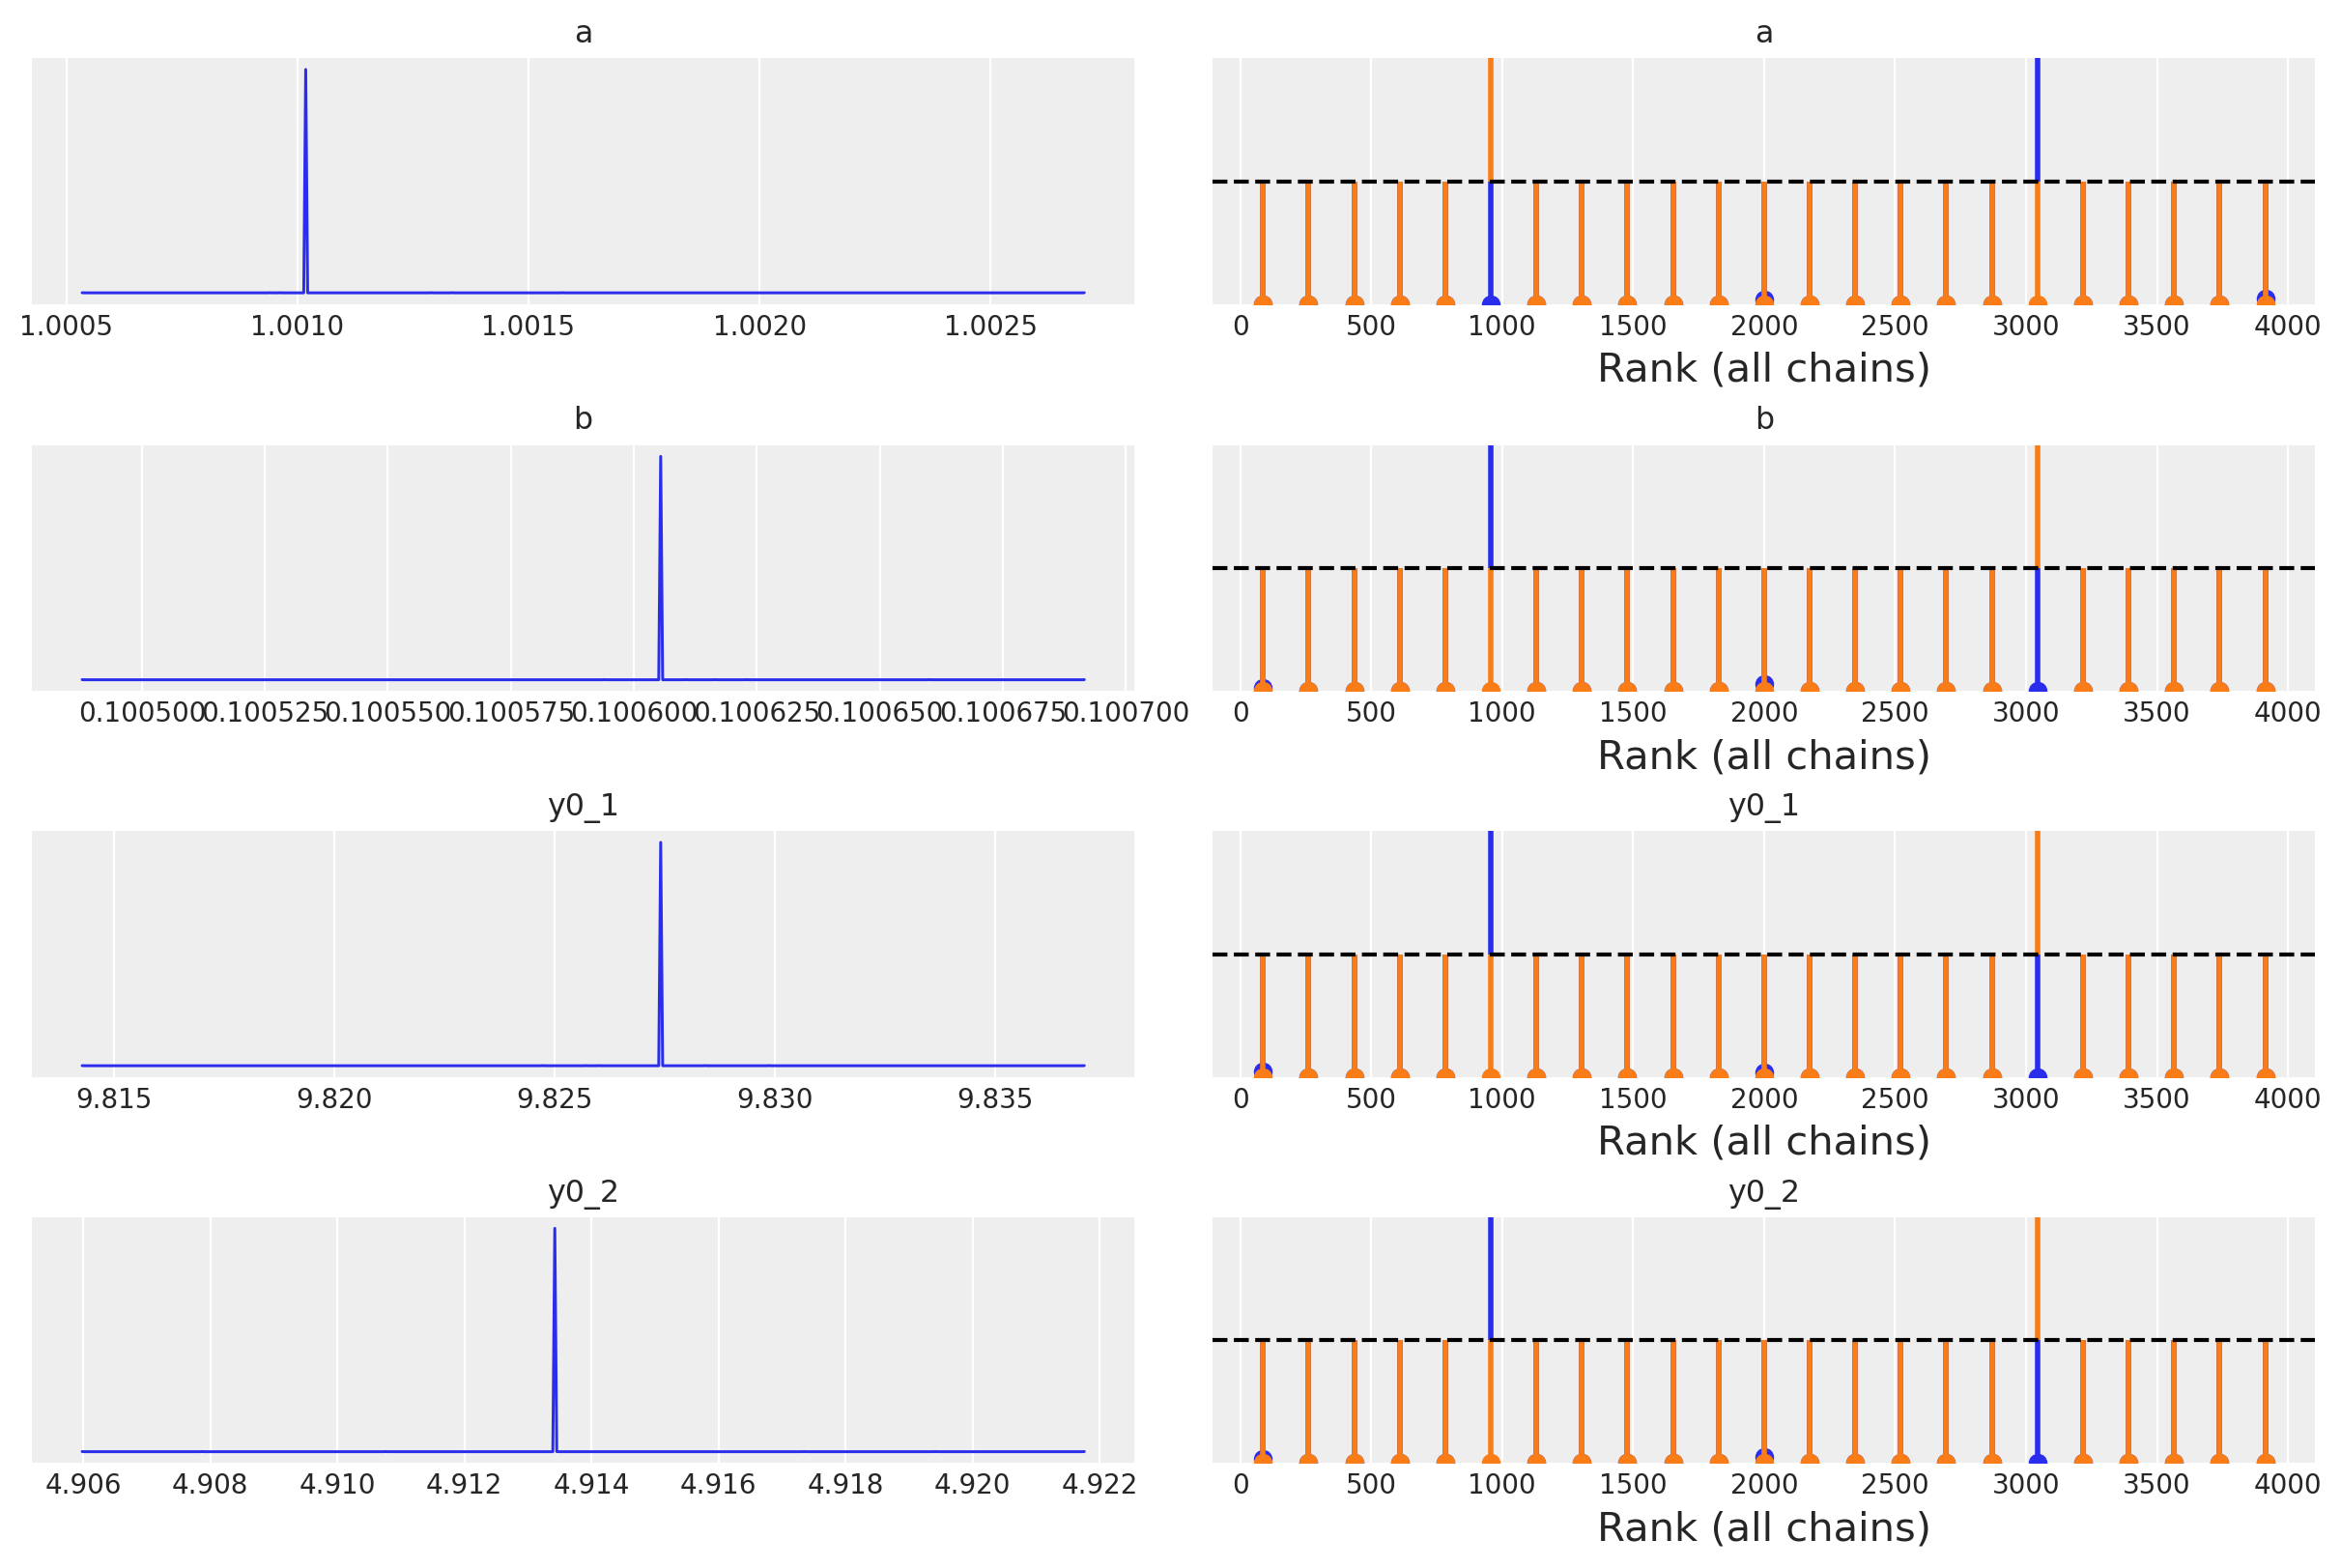

In [13]:
az.plot_trace(idata_lv, kind="rank_vlines");

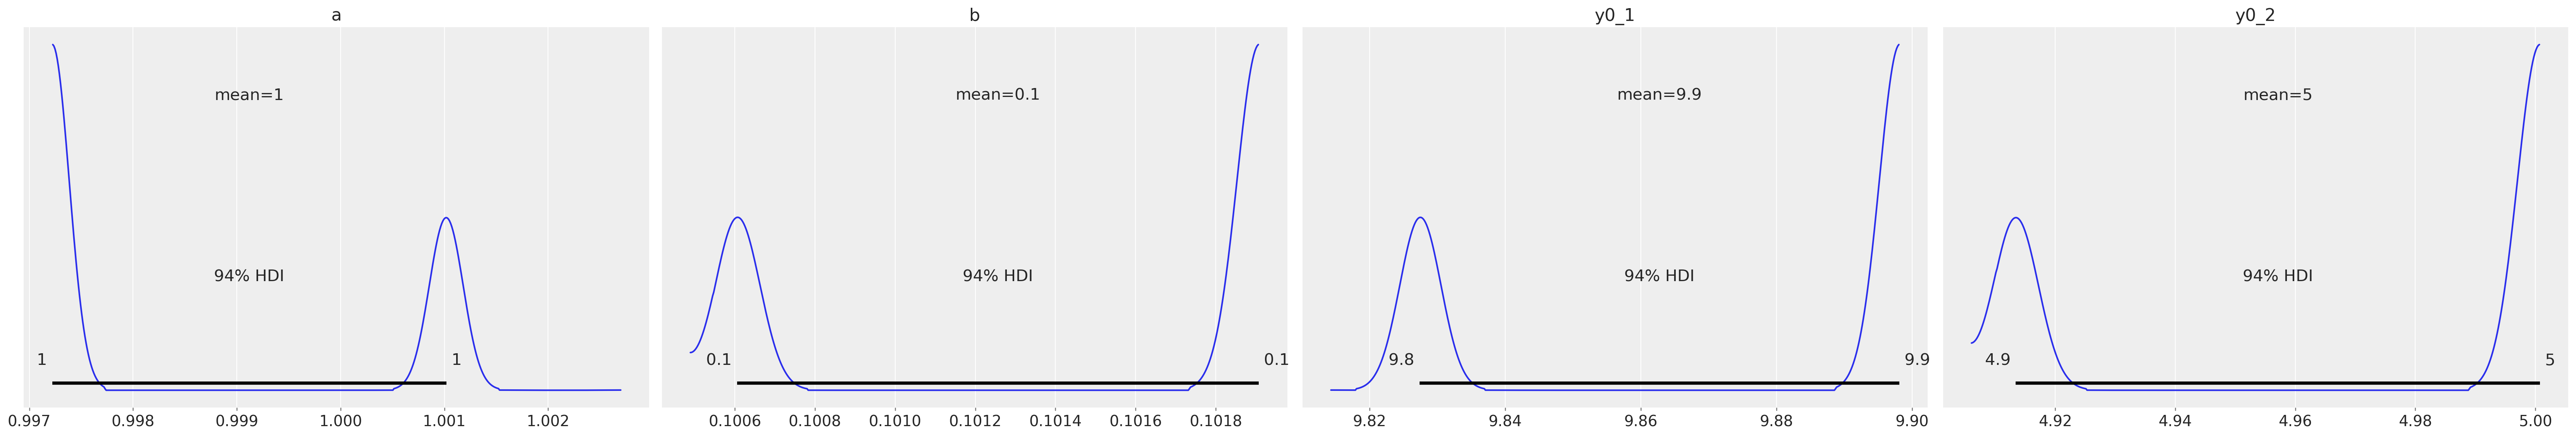

In [14]:
az.plot_posterior(idata_lv);

In [15]:
print(az.summary(idata_lv))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
print(posterior["y0_1"].mean(), posterior["y0_2"].mean())


/opt/homebrew/Caskroom/mambaforge/base/envs/pymcmain/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.999,0.002,0.997,1.001,0.001,0.001,2.0,2.0,9.15
b,0.101,0.001,0.101,0.102,0.000,0.000,2.0,2.0,11.67
y0_1,9.863,0.035,9.827,9.898,0.025,0.021,2.0,2.0,9.16
y0_2,4.957,0.044,4.913,5.001,0.031,0.026,2.0,2.0,10.13


<xarray.DataArray 'y0_1' ()>
array(9.862754)

<xarray.DataArray 'y0_2' ()>
array(4.95709966)

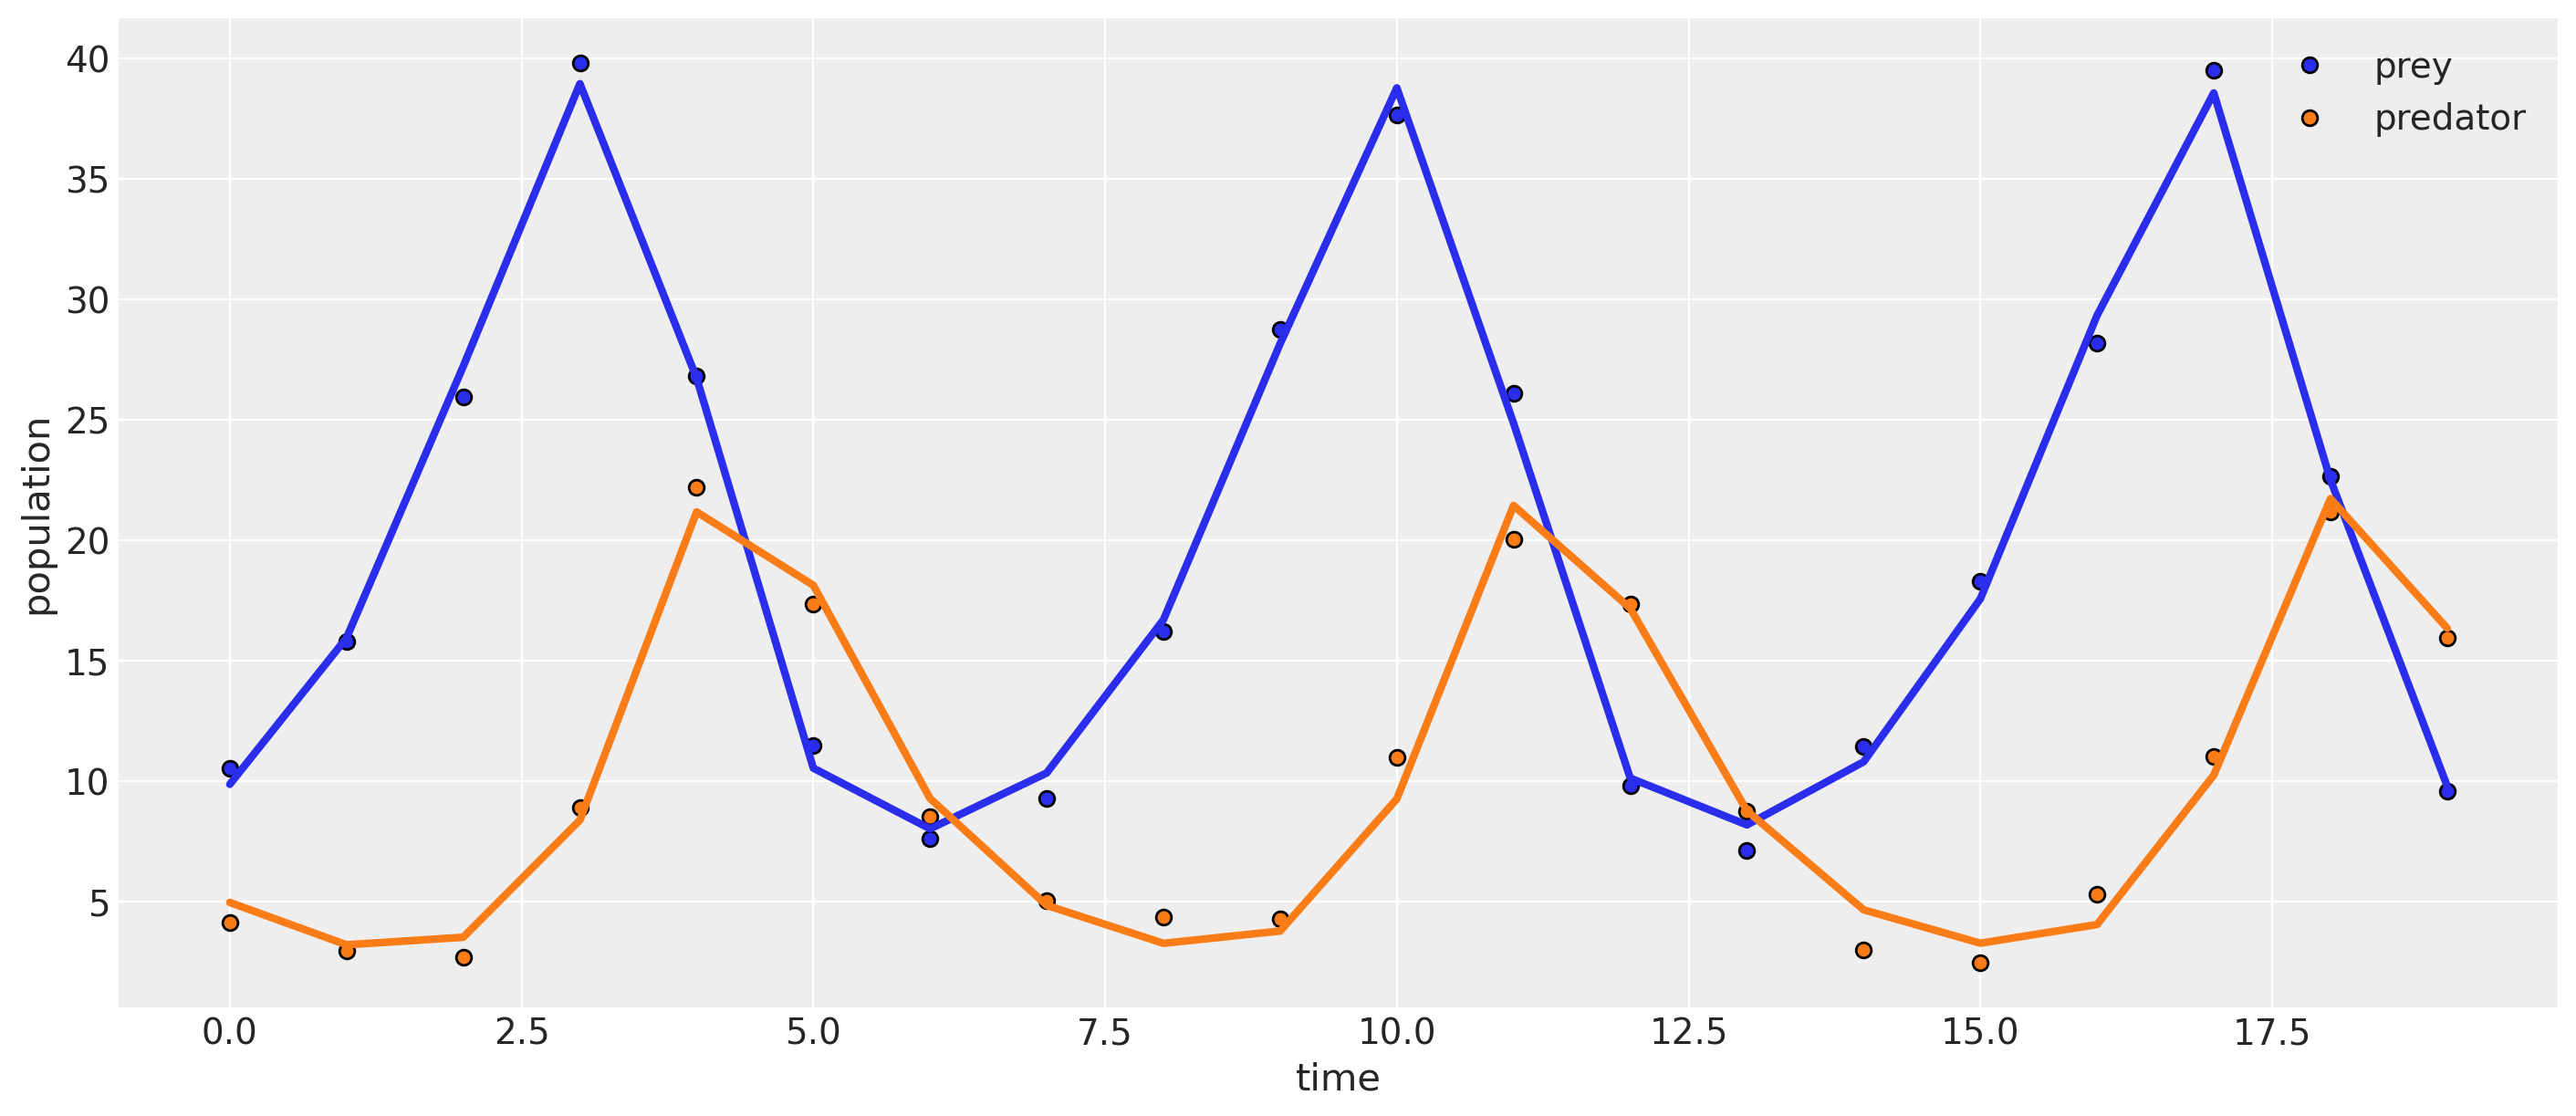

In [17]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
posterior = idata_lv.posterior.stack(samples=("draw", "chain"))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")

y_posterior = ( posterior["y0_1"].mean(), posterior["y0_2"].mean())
# y_posterior = (10, 5)
ax.plot(competition_model(None, y_posterior, posterior["a"].mean(), posterior["b"].mean()), linewidth=3)
# for i in np.random.randint(0, size, 10):
#     sim = competition_model(None, (posterior["y0_1"][i], posterior["y0_2"][i]), posterior["a"][i], posterior["b"][i])
#     ax.plot(sim[:, 0], alpha=0.1, c="C0")
#     ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();